# Akoya Academy Webinar: PhenoImager Analysis
This notebook contains the necessary libraries and steps to import the single cell data from QuPath into Python. The files exported from QuPath are stored under `data/` folder.
## Step-3: Automated Cell Phenotyping
Step-3 covers the automated cell phenotyping using the `scimap` library. More information about this library can be found [here](https://scimap.xyz).


### Import necessary libararies

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from skimage import io

# Load necessary libraries
import numpy as np

import anndata as ad
import pandas as pd
import scanpy as sc
import scimap as sm

import seaborn as sns; sns.set(color_codes=True)

#ignore warnings
import warnings
warnings.filterwarnings('ignore')

In [2]:
# read in the data
adata = sc.read_h5ad('data/adata.h5ad')


In [3]:
# for each marker clip value to mean of top 20 values
def mediantop20(subAD):
    outAD = subAD.copy()
    for ix,x in enumerate(outAD.var_names):
        aX = subAD[:,x].X.flatten()
        top20 = np.sort(aX)[-20:]
        outAD.X[:,ix] = np.clip(subAD[:,x].X.flatten(),0,np.median(top20))
    return outAD

# remove expression outliers from the data
def removeOutliers(ad):

    # separate each sample
    s = {}
    for sID in ad.obs.ImageID.sort_values().unique():
        print(sID)
        s[sID] = ad[ad.obs['ImageID']==sID]
        print(s[sID].X.max(axis=0))
        s[sID] = mediantop20(s[sID])
        print(s[sID].X.max(axis=0))
    outAD = sc.concat(s.values())
    return outAD

In [4]:
newAD = removeOutliers(adata)

NSCLC_S1
[111.9368  54.726   27.4466  29.1536  53.797   36.326 ]
[82.2979  42.78735 20.32865 19.43    37.6481  24.89415]
NSCLC_S2
[49.3463 36.3336 16.7257 31.3867 40.9168 16.1421]
[41.7076   31.825748 12.9072   26.627499 33.276604 13.7048  ]


### Rescale data

The scimap's pp.rescale function uses two-component Gaussian Mixture Model. We run this for each sample independently since they may have different expression ranges. More information can be found [here](https://scimap-doc.readthedocs.io/en/latest/pp/sm.pp.rescale/).

In [5]:
newAD = sm.pp.rescale(newAD,imageid='ImageID', method='by_image')

GMM for ['NSCLC_S1']
Finding the optimal gate by GMM for CD8
Finding the optimal gate by GMM for CD4
Finding the optimal gate by GMM for CD3E
Finding the optimal gate by GMM for CD20
Finding the optimal gate by GMM for PanCK
Finding the optimal gate by GMM for CD68
GMM for ['NSCLC_S2']
Finding the optimal gate by GMM for CD8
Finding the optimal gate by GMM for CD4
Finding the optimal gate by GMM for CD3E
Finding the optimal gate by GMM for CD20
Finding the optimal gate by GMM for PanCK
Finding the optimal gate by GMM for CD68
Scaling Image NSCLC_S1
Scaling CD8
Scaling CD4
Scaling CD3E
Scaling CD20
Scaling PanCK
Scaling CD68
Scaling Image NSCLC_S2
Scaling CD8
Scaling CD4
Scaling CD3E
Scaling CD20
Scaling PanCK
Scaling CD68


Read in the phenotype rules file. 

In [6]:
phenoDF = pd.read_csv('data/IP_phenotype.csv')
phenoDF

,Unnamed: 0,Unnamed: 1,CD8,CD4,CD3E,CD20,PanCK,CD68
0,all,B cells,NaN,NaN,NaN,pos,NaN,NaN
1,all,T cells,NaN,NaN,pos,NaN,NaN,NaN
2,all,Tumor,NaN,NaN,NaN,NaN,pos,NaN
3,all,Macrophages,NaN,NaN,NaN,NaN,NaN,pos
4,T cells,CD8+ T cells,pos,NaN,NaN,NaN,NaN,NaN
5,T cells,CD4+ T cells,NaN,pos,NaN,NaN,NaN,NaN


### Compute cell phenotypes

Using scimap's `tl.phenotype_cells()` function and the rules in phenoDF, compute the cell phenotypes. More information can be found [here](https://scimap-doc.readthedocs.io/en/latest/tl/sm.tl.phenotype_cells/).

In [7]:

sm.tl.phenotype_cells(newAD,phenoDF,label='phenotype')

Phenotyping B cells
Phenotyping T cells
Phenotyping Tumor
Phenotyping Macrophages
-- Subsetting T cells
Phenotyping CD8+ T cells
Phenotyping CD4+ T cells
Consolidating the phenotypes across all groups


AnnData object with n_obs × n_vars = 438289 × 6
    obs: 'spatial_X', 'spatial_Y', 'Area', 'ImageID', 'phenotype'
    uns: 'gates'

In [9]:
newAD.obs.groupby('ImageID').phenotype.value_counts()

ImageID   phenotype   
NSCLC_S1  Tumor           181727
          Macrophages      31826
          Unknown          25172
          CD4+ T cells     15971
          CD8+ T cells     10823
          B cells            838
          T cells            541
NSCLC_S2  Tumor            60513
          Unknown          38026
          Macrophages      29281
          CD4+ T cells     22729
          B cells          10549
          CD8+ T cells      9776
          T cells            517
Name: phenotype, dtype: int64

In [10]:
# Save x and y coordinates in scanpy's obsm for easy plotting
newAD.obsm['X_spatial'] = newAD.obs[['spatial_X','spatial_Y']].values


In [11]:
# Assign colors to each cell type
cMap = {'B cells':'#6A0FBA',
       'CD4+ T cells':'#FFC400',
       'CD8+ T cells':'#0000FF',
       'Macrophages':'#00DBF2',
        'T cells':'#A3500C',
        'Tumor': '#FF0055',
       }

### Plot cell phenotypes

Trying to set attribute `.obs` of view, copying.
... storing 'ImageID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'phenotype' as categorical


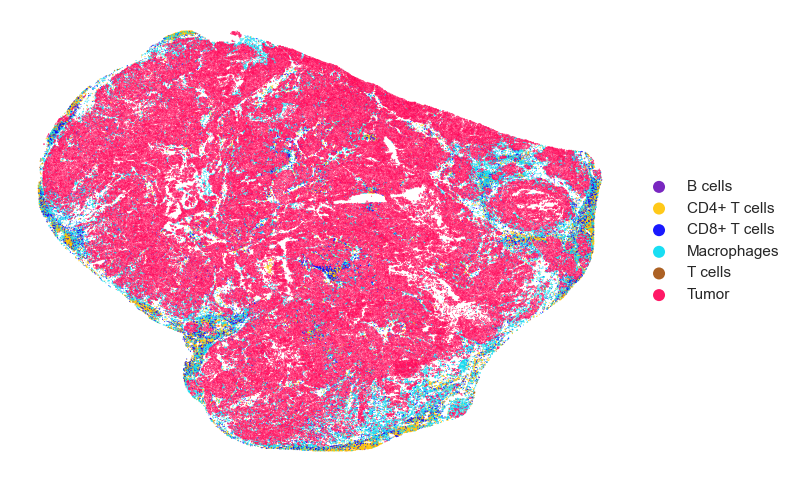

In [18]:
fig,ax=plt.subplots(1,1,figsize=(8,6))
ax.invert_yaxis()
ax.axis('off')
ss = newAD[(newAD.obs.ImageID=='NSCLC_S1')&(newAD.obs.phenotype!='Unknown')]
sc.pl.scatter(ss,basis='spatial',color=['phenotype'],ax=ax,size=2,title='',
              alpha=0.9, palette=cMap.values())


Trying to set attribute `.obs` of view, copying.
... storing 'ImageID' as categorical
Trying to set attribute `.obs` of view, copying.
... storing 'phenotype' as categorical


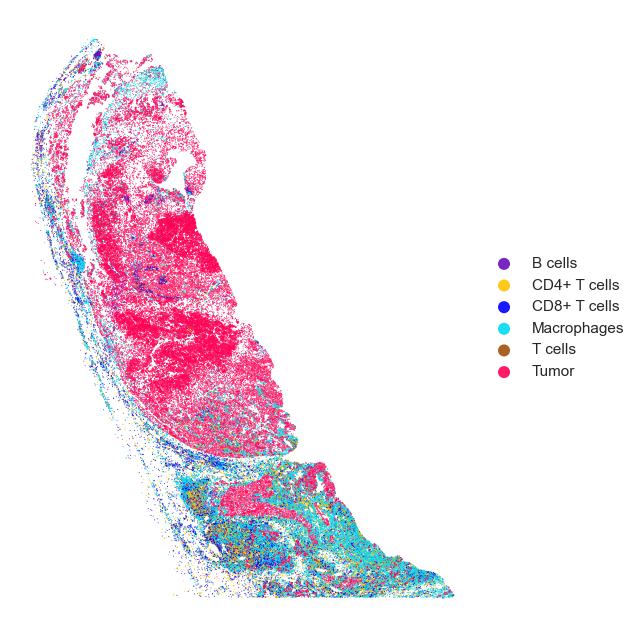

In [12]:
fig,ax=plt.subplots(1,1,figsize=(6,8))
ax.invert_yaxis()
ax.axis('off')
ss = newAD[(newAD.obs.ImageID=='NSCLC_S2')&(newAD.obs.phenotype!='Unknown')]
sc.pl.scatter(ss,basis='spatial',color=['phenotype'],ax=ax,size=2,title='',
              alpha=0.9, palette=cMap.values())


### Save data for downstream analysis
If the phenotyping is satisfactory, save the annotated data for next steps.

In [19]:
newAD.write_h5ad('data/adata_phenotypes.h5ad')

... storing 'ImageID' as categorical
... storing 'phenotype' as categorical
